#Predictive analysis, target feature: SFN treatment

**Load libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/eeg data/totall_df.csv'

In [4]:
df = pd.read_csv(path)
df.tail()

,Example_names,F1_th/al,F1_th/beta,F1_th/gama,F2_th/al,F2_th/beta,F2_th/gama,T1_th/al,T1_th/beta,T1_th/gama,...,O1_th/gama,O2_th/al,O2_th/beta,O2_th/gama,Example,Day_time_h,Event_type,SFN_treat,Num_per_h,Dur_per_h
3322,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.376390,0.808605,14.442618,0.354407,0.646204,12.138190,0.413740,0.983833,23.487378,...,13.437017,0.360715,0.590758,7.511864,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3323,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.444862,0.883468,14.071816,0.413103,0.788776,13.421757,0.410607,0.911440,20.187075,...,14.771327,0.456566,0.861803,11.286298,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3324,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.471139,0.874434,11.718948,0.449249,0.813695,11.918224,0.431847,0.903160,16.261716,...,13.442645,0.508233,0.921530,9.931513,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3325,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.377731,0.824558,13.373822,0.348138,0.699460,12.694106,0.371347,0.898335,16.742484,...,13.953187,0.369664,0.693528,9.799755,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3326,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.534603,1.093385,19.617927,0.472650,0.777563,13.089325,0.474034,1.066304,24.289437,...,20.030298,0.517533,0.879643,13.251053,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0


In [5]:
df.shape

(3327, 31)

In [6]:
# Fianl column manupulations
df_new = df.drop(columns = ['Example_names', 'Example', 'Dur_per_h'])
df_new['Event_type'] = df_new['Event_type'].replace ('Seizure', 'SEIZURE')
import pandas as pd

column_to_move = 'B'
df_new = df_new[[col for col in df_new.columns if col !='SFN_treat'] + ['SFN_treat']]

print (df_new.columns)
df_new['Event_type'].nunique()

Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'Day_time_h',
       'Event_type', 'Num_per_h', 'SFN_treat'],
      dtype='object')


3

In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3327 entries, 0 to 3326
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   F1_th/al    3327 non-null   float64
 1   F1_th/beta  3327 non-null   float64
 2   F1_th/gama  3327 non-null   float64
 3   F2_th/al    3327 non-null   float64
 4   F2_th/beta  3327 non-null   float64
 5   F2_th/gama  3327 non-null   float64
 6   T1_th/al    3327 non-null   float64
 7   T1_th/beta  3327 non-null   float64
 8   T1_th/gama  3327 non-null   float64
 9   T2_th/al    3327 non-null   float64
 10  T2_th/beta  3327 non-null   float64
 11  T2_th/gama  3327 non-null   float64
 12  P1_th/al    3327 non-null   float64
 13  P1_th/beta  3327 non-null   float64
 14  P1_th/gama  3327 non-null   float64
 15  P2_th/al    3327 non-null   float64
 16  P2_th/beta  3327 non-null   float64
 17  P2_th/gama  3327 non-null   float64
 18  O1_th/al    3327 non-null   float64
 19  O1_th/beta  3327 non-null  

In [8]:
# Defining target column
X= df_new.drop(columns = ['SFN_treat'])
y = df_new['SFN_treat']

In [9]:
# Define the feature groups: numerical and categorical
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
print ('Numerical features:')
print (numerical_features)
print ('Categorical features:')
print (categorical_features)

Numerical features:
Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'Num_per_h'],
      dtype='object')
Categorical features:
Index(['Day_time_h', 'Event_type'], dtype='object')


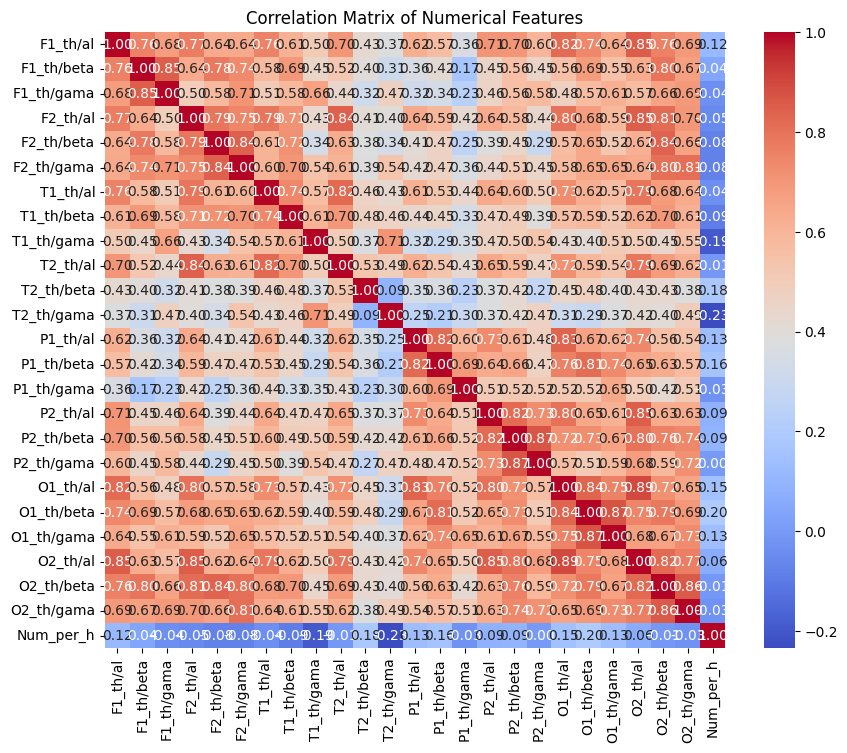

In [10]:
correlation_matrix = df_new[numerical_features].corr()

# Візуалізація кореляційної матриці
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

**Checking data for multicollinearity**

In [11]:
# Choose labels with correlation > 0.9
high_corr_pairs = np.where(correlation_matrix > 0.9)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j])
                   for i, j in zip(*high_corr_pairs) if i != j]
high_corr_pairs

[]

In [12]:
# Setting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2661, 27), (666, 27), (2661,), (666,))

In [13]:
# Transforming target feature to binary format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [14]:
# Creating Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(sparse_output=False))]), categorical_features)
    ]
)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', max_depth=4, eta=0.1, n_estimators=100))
])

In [15]:
# Model training

model.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Model cross-validation**

In [16]:
cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='accuracy')

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean accuracy: {np.mean(cv_scores)}')
print(f'Standard deviation: {np.std(cv_scores)}')

Cross-validation scores: [0.96247655 0.95300752 0.95300752 0.94736842 0.95112782]
Mean accuracy: 0.953397565207578
Standard deviation: 0.004984666943429382


In [17]:
# Estimation by different metrics of accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='macro')
recall = recall_score(y_test_encoded, y_pred, average='macro')
f1 = f1_score(y_test_encoded, y_pred, average='macro')
report = classification_report(y_test_encoded, y_pred)

# Виведення результатів
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(report)

Accuracy: 0.9669669669669669
Precision: 0.9671065092493213
Recall: 0.9671065092493213
F1 Score: 0.9669669669669669
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       337
           1       0.96      0.98      0.97       329

    accuracy                           0.97       666
   macro avg       0.97      0.97      0.97       666
weighted avg       0.97      0.97      0.97       666



In [18]:
with open('classification_report_modell_treatment.txt', 'w') as file:
    file.write(report)

**Visualization Precision-Recall curve**

In [19]:
# Prediction possibility for train and test data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

In [20]:
# Prediction possibility for train and test data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

In [21]:
# Binarization of target train and test features
y_train_bin = label_binarize(y_train_encoded, classes=[0, 1])
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1])

In [22]:
# Calculation Precision-Recall curves for train and test data
precision_train, recall_train, _ = precision_recall_curve(y_train_bin, y_train_prob)
precision_test, recall_test, _ = precision_recall_curve(y_test_bin, y_test_prob)

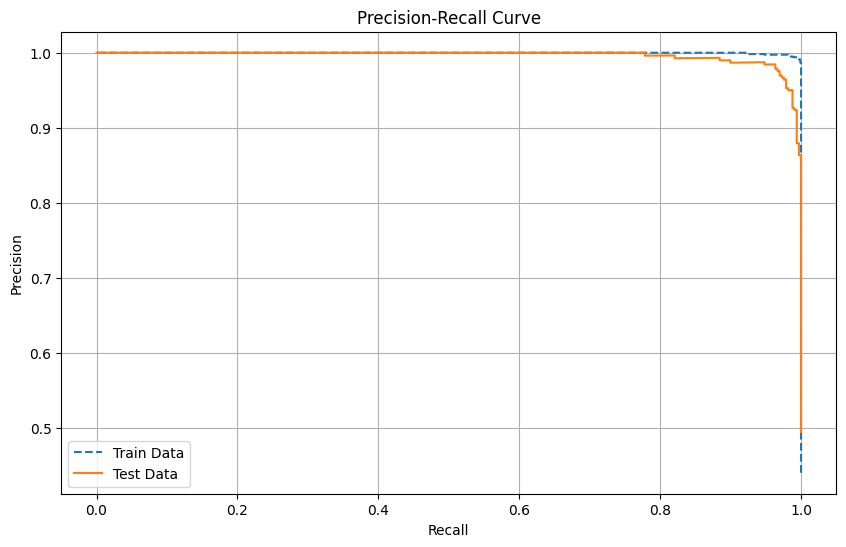

In [23]:
# Graph Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(recall_train, precision_train, label="Train Data", linestyle='--')
plt.plot(recall_test, precision_test, label="Test Data", linestyle='-')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.savefig('Precision-Recall Curve.png')
plt.show()

In [24]:
# Calculation ROC curves for train and test data
fpr_train, tpr_train, _ = roc_curve(y_train_bin, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_bin, y_test_prob)

In [25]:
# Calculation AUC for train and test data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

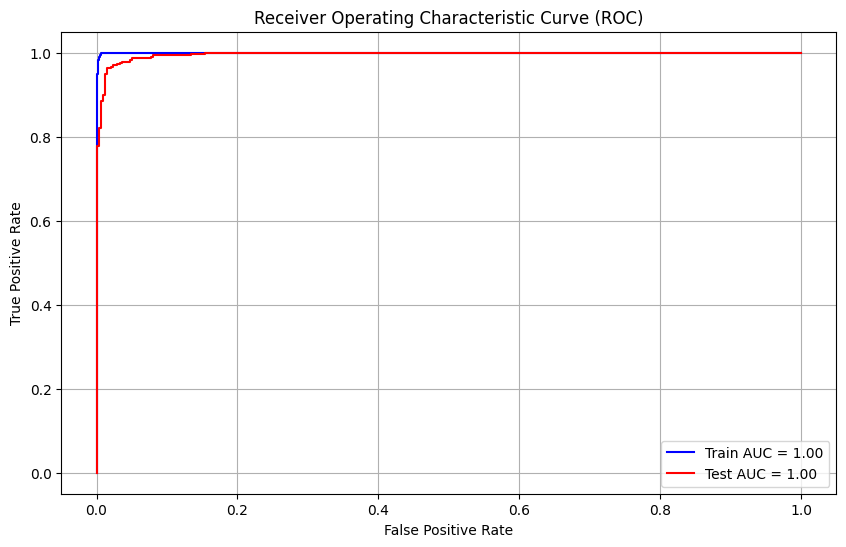

In [26]:
# ROC graph
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_train:.2f}", color='blue')
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.2f}", color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC Curve.png')
plt.show()

**Defining features' impotance**

In [27]:
importances = model.named_steps['classifier'].feature_importances_

# Getting all columns after transformation
categorical_columns_transformed = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(np.concatenate([numerical_features, categorical_columns_transformed]))
all_feature_names

['F1_th/al',
 'F1_th/beta',
 'F1_th/gama',
 'F2_th/al',
 'F2_th/beta',
 'F2_th/gama',
 'T1_th/al',
 'T1_th/beta',
 'T1_th/gama',
 'T2_th/al',
 'T2_th/beta',
 'T2_th/gama',
 'P1_th/al',
 'P1_th/beta',
 'P1_th/gama',
 'P2_th/al',
 'P2_th/beta',
 'P2_th/gama',
 'O1_th/al',
 'O1_th/beta',
 'O1_th/gama',
 'O2_th/al',
 'O2_th/beta',
 'O2_th/gama',
 'Num_per_h',
 'Day_time_h_12-16',
 'Day_time_h_4-8',
 'Event_type_IED',
 'Event_type_MS',
 'Event_type_SEIZURE']

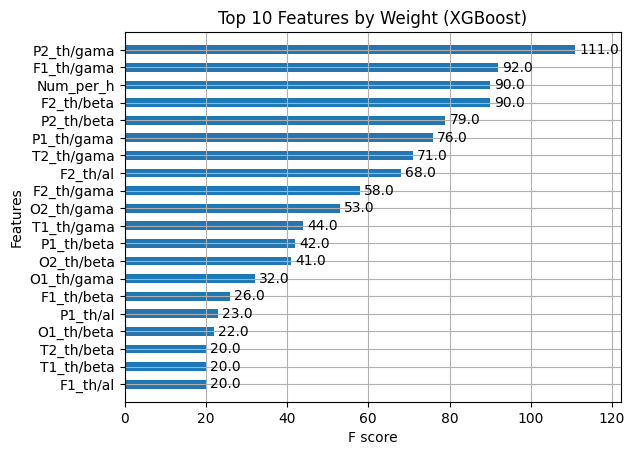

In [28]:
# Input all_feature_names into XGBoost model
model.named_steps['classifier'].get_booster().feature_names = all_feature_names

# Graph for features impotance
xgb.plot_importance(model.named_steps['classifier'],
                    importance_type='weight',
                    max_num_features=20,
                    height=0.5)

plt.title("Top 10 Features by Weight (XGBoost)")
plt.savefig('Top 10 Features by Weight (XGBoost).png')
plt.show()


#Clastering

**Clustering by frequency of epileptic episode**

In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [30]:
# Getting datasets by the fact of treatment
df_treatment = df_new[df_new['SFN_treat'] == 'SFN']
df_no_treatment = df_new[df_new['SFN_treat'] == 'No_SFN']

In [31]:
print(df_treatment.columns)
print(df_no_treatment.columns)

Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'Day_time_h',
       'Event_type', 'Num_per_h', 'SFN_treat'],
      dtype='object')
Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'Day_time_h',
       'Event_type', 'Num_per_h', 'SFN_treat'],
      dtype='object')


In [32]:
# Вибираємо ознаки для кластеризації (включаючи "частоту проявів")
features = ['Num_per_h']
X_treatment = df_treatment[features]
X_no_treatment = df_no_treatment[features]

In [33]:
# Data standartization
scaler = StandardScaler()
X_treatment_scaled = scaler.fit_transform(X_treatment)
X_no_treatment_scaled = scaler.fit_transform(X_no_treatment)

In [34]:
# Fuction for finding the optimal number of clasters (elbow method)
def find_optimal_clusters(data, max_k):
    distortions = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    return distortions

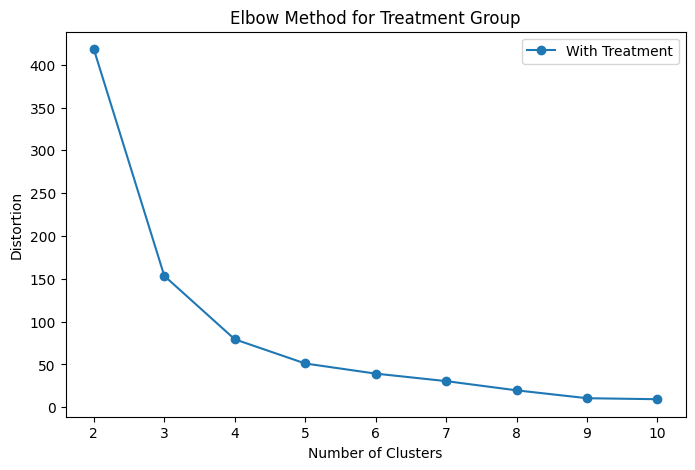

In [35]:
# Elbow graph for the group with SFN treatment
distortions_treatment = find_optimal_clusters(X_treatment_scaled, 10)
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), distortions_treatment, marker='o', label='With Treatment')
plt.title("Elbow Method for Treatment Group")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.legend()
plt.savefig('Elbow method results for clastering(modell by treatment)')
plt.show()

In [36]:
# Clasterization (k=3)
k = 3
kmeans_treatment = KMeans(n_clusters=k, random_state=42)
kmeans_no_treatment = KMeans(n_clusters=k, random_state=42)

clusters_treatment = kmeans_treatment.fit_predict(X_treatment_scaled)
clusters_no_treatment = kmeans_no_treatment.fit_predict(X_no_treatment_scaled)

In [37]:
# Adding claters to dataset
df_treatment['cluster'] = clusters_treatment
df_no_treatment['cluster'] = clusters_no_treatment

<ipython-input-37-a49172d64265>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treatment['cluster'] = clusters_treatment
<ipython-input-37-a49172d64265>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_treatment['cluster'] = clusters_no_treatment


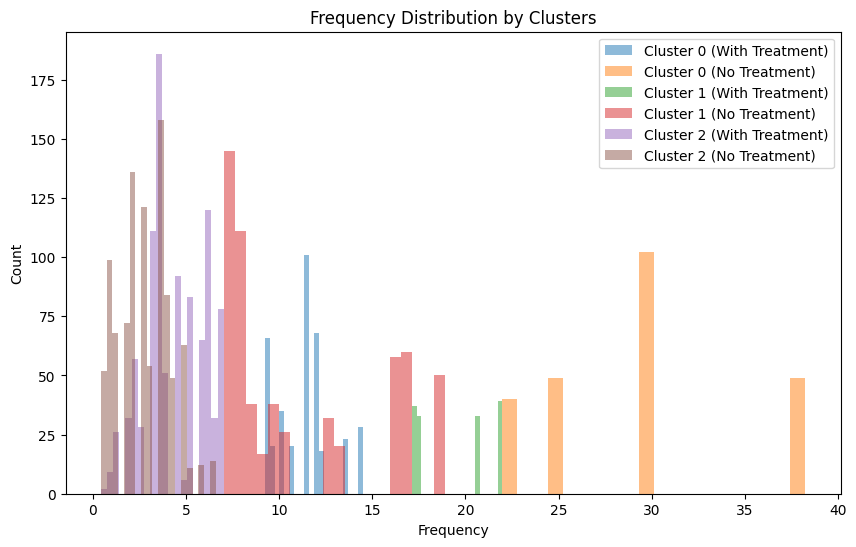

In [38]:
# Visualization clasters  by number of ep.events per hour
plt.figure(figsize=(10, 6))
for cluster in range(k):
    plt.hist(
        df_treatment[df_treatment['cluster'] == cluster]['Num_per_h'],
        alpha=0.5, bins=20, label=f'Cluster {cluster} (With Treatment)'
    )
    plt.hist(
        df_no_treatment[df_no_treatment['cluster'] == cluster]['Num_per_h'],
        alpha=0.5, bins=20, label=f'Cluster {cluster} (No Treatment)'
    )

plt.xlabel("Frequency")
plt.ylabel("Count")
plt.title("Frequency Distribution by Clusters")
plt.legend()
plt.savefig('Frequency_distribution_by_clusters.png')
plt.show()

In [39]:
# Обчислюємо середні значення для кожного кластеру з лікуванням і без
treatment_means = df_treatment.groupby('cluster')['Num_per_h'].mean()
no_treatment_means = df_no_treatment.groupby('cluster')['Num_per_h'].mean()

# Об'єднуємо ці значення в один DataFrame
cluster_means_df = pd.DataFrame({
    'With Treatment': treatment_means,
    'No Treatment': no_treatment_means
})

# Виводимо результат
print(cluster_means_df)


         With Treatment  No Treatment
cluster                              
0             11.266201     29.296703
1             19.390187     11.028904
2              4.331783      2.756438


In [40]:
cluster_means_df.to_csv('mean_values_by_claters_modell_treatment.csv')

**Summary:**

Some EEG records with a high event rate (cluster 0) moved to a group with a low or moderate seizure frequency after treatment. EEG records with a low-frequency event rate retained their low frequency even after treatment, although there may be a slight increase in the number of events in this group. This may indicate that the treatment helped to reduce the frequency of seizures in EEG records with a high frequency of event rate, possibly even moving them into the low- or intermediate-frequency groups.
